In [24]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt; plt.set_cmap('gray')
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from mesh_detection.dataset import FaceDataset
from mesh_detection.batch_iter import batch_iterator
from mesh_detection.utils import add_channel_dim, randomly_flip, show_key_points, to_torch, to_np, sequence_to_torch
from mesh_detection.split import train_val_test_split, stratified_train_val_test_split
from mesh_detection.model import BitNet, predict
from mesh_detection.train import validator, train, criterion
from mesh_detection.metric import l2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Dataset

In [26]:
kaggle_face_path = Path('../../kaggle_face/training.csv')

In [27]:
ds = FaceDataset(kaggle_face_path)

In [28]:
i = np.random.choice(ds.ids)

In [29]:
img = ds.load_image(i)
kps = ds.load_key_points(i)

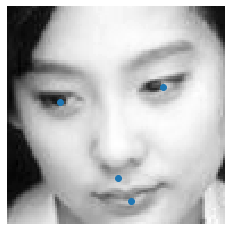

In [30]:
plt.axis('off')
plt.imshow(img)
show_key_points(kps)

# Split

In [32]:
contain_nans = [np.any(np.isnan(ds.load_key_points(i))) for i in ds.ids]

In [33]:
train_ids, val_ids, test_ids = stratified_train_val_test_split(ds.ids, labels=contain_nans)[0]

# Batch iterator

In [34]:
batch_iter = batch_iterator(ds.load_image, ds.load_key_points, train_ids[:100], 50, randomly_flip, add_channel_dim)

In [35]:
batch_iter

<function mesh_detection.batch_iter.batch_iterator.<locals>.iterate_batches()>

# Model

In [36]:
stucture = [
    [[1, 16, 16],                     [16, 32, 32]],
        [[16, 32, 32],                [32, 64, 64]],
            [[32, 64, 64],            [64, 128, 128]],
                [[64, 128, 128],      [128, 256, 256]],
                    [[128, 256, 256], [256, 512, 512]],
                        [256, 512, 512]
]

n_points = 15
conv_block = partial(nn.Conv2d, kernel_size=3, padding=1)
pooling = partial(nn.MaxPool2d, kernel_size=2)

model = BitNet(stucture, n_points, conv_block, pooling)

# Train

In [37]:
optimizer = Adam(model.parameters(), lr=1e-3)

In [38]:
validate = validator(val_ids, ds.load_image, ds.load_key_points, {'l2': l2})

In [39]:
model, losses, val_metrics = train(model, batch_iter, optimizer, criterion, n_epochs=3, validate=validate)

In [40]:
val_metrics

{'l2': [array([69.89153 , 41.676254, 63.19246 , 76.834145, 45.476032, 37.256134,
         56.673073, 80.31972 , 41.88741 , 27.930115, 71.849205, 91.77658 ,
         75.46656 , 81.090485, 85.41636 ], dtype=float32),
  array([68.58003 , 40.048843, 61.248005, 75.01453 , 43.2679  , 35.14006 ,
         54.941414, 78.40216 , 40.01216 , 25.754887, 69.75034 , 90.31416 ,
         73.72393 , 78.98531 , 83.578445], dtype=float32),
  array([67.97988 , 39.431583, 61.05462 , 74.6201  , 42.87862 , 34.723732,
         54.49417 , 78.193665, 39.058353, 25.169722, 69.20157 , 89.78735 ,
         73.11185 , 78.44504 , 83.03669 ], dtype=float32)]}